<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/AF')

In [2]:
from util import util, model_util
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np
import sklearn
from sklearn import metrics
print(tf.__version__)
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average

2.3.1


In [78]:
# load training data
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)
signals, labels = util.preprocessing(signals, labels, timedistributed=False)
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9)
print('train_signal shape:', train_signals.shape)
print('val_signal shape:', val_signals.shape)


train_signal shape: (7425, 3750, 1)
val_signal shape: (825, 3750, 1)


In [79]:
r_train_signals = train_signals.reshape((-1,1250,1))
r_val_signals = val_signals.reshape((-1,1250,1))

In [80]:
# load testing data
test_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/validation/"
test_raw_signals, test_raw_labels = util.data_mining(test_data_file_path)
test_signals, test_labels = util.generate_seg_data(test_raw_signals, test_raw_labels, seg_len=9000)
test_signals, test_labels = util.preprocessing(test_signals, test_labels, timedistributed=False)
print('test_signal shape:', test_signals.shape)
r_test_signals = test_signals.reshape((-1,1250,1))
r_test_signals.shape

test_signal shape: (276, 3750, 1)


(828, 1250, 1)

In [81]:
min_val = tf.reduce_min(r_train_signals)
max_val = tf.reduce_max(r_train_signals)

r_train_signals = (r_train_signals - min_val) / (max_val - min_val)
r_val_signals = (r_val_signals - min_val) / (max_val - min_val)
r_test_signals = (r_test_signals - min_val) / (max_val - min_val)

r_train_signals = tf.cast(r_train_signals, tf.float32)
r_val_signals = tf.cast(r_val_signals, tf.float32)
r_test_signals = tf.cast(r_test_signals, tf.float32)

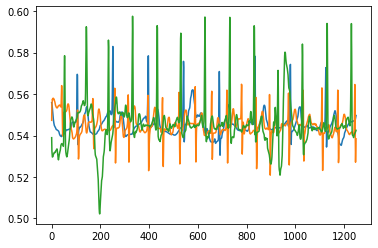

In [82]:
import matplotlib.pyplot as plt
plt.plot(r_train_signals[1])
plt.plot(r_val_signals[0])
plt.plot(r_test_signals[0])

In [83]:
class Autoencoder(Model):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            Input(shape=input_shape),
            Conv1D(256, 3, activation='relu', padding='same', strides=1),
            Conv1D(64, 3, activation='relu', padding='same', strides=1),
            Conv1D(16, 3, activation='relu', padding='same', strides=1),

        ])

        self.decoder = tf.keras.Sequential([
            Conv1DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
            Conv1DTranspose(64, kernel_size=3, strides=1, activation='relu', padding='same'),
            Conv1DTranspose(256, kernel_size=3, strides=1, activation='relu', padding='same'),
            Conv1D(1, kernel_size=3, activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [84]:
autoencoder.summary()

Model: "autoencoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 1250, 16)          53328     
_________________________________________________________________
sequential_10 (Sequential)   (None, 1250, 1)           54097     
Total params: 107,425
Trainable params: 107,425
Non-trainable params: 0
_________________________________________________________________


In [85]:
autoencoder = Autoencoder(input_shape=(1250,1))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError())

autoencoder.fit(r_train_signals,r_train_signals,
                batch_size=64,
                epochs=10,
                shuffle=True,
                validation_data=(r_val_signals,r_val_signals))

Epoch 1/10
349/349 [==============================] - 12s 34ms/step - loss: 8.3578e-05 - val_loss: 9.1827e-05
Epoch 2/10
349/349 [==============================] - 12s 35ms/step - loss: 2.5463e-05 - val_loss: 1.4288e-05
Epoch 3/10
349/349 [==============================] - 13s 36ms/step - loss: 9.0055e-06 - val_loss: 3.7003e-05
Epoch 4/10
349/349 [==============================] - 13s 38ms/step - loss: 4.5545e-06 - val_loss: 8.7602e-06
Epoch 5/10
349/349 [==============================] - 13s 39ms/step - loss: 5.3555e-06 - val_loss: 2.4023e-05
Epoch 6/10
349/349 [==============================] - 14s 39ms/step - loss: 4.0126e-06 - val_loss: 3.0168e-06
Epoch 7/10
349/349 [==============================] - 14s 39ms/step - loss: 3.4505e-06 - val_loss: 9.9151e-07
Epoch 8/10
349/349 [==============================] - 14s 39ms/step - loss: 3.8020e-06 - val_loss: 1.8440e-06
Epoch 9/10
349/349 [==============================] - 14s 39ms/step - loss: 4.6040e-06 - val_loss: 7.6349e-07
Epoch 10/1

In [86]:
encoded_signals = autoencoder.encoder(r_test_signals).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

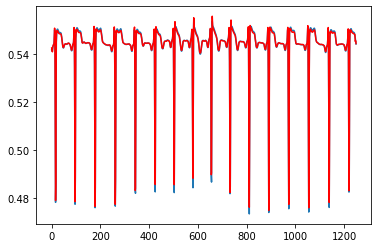

In [89]:
plt.plot(r_test_signals[50])
plt.plot(decoded_signals[50],'r')

In [93]:
import os
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models")
autoencoder.save_weights('ECG_AutoEncoder.h5')